In [1]:
# importing the required libraries
import pandas as pd
import spacy
from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import re
import spacy
import gensim.downloader as api
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten, Dropout, SimpleRNN, Bidirectional
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

In [2]:
!python -m spacy download en_core_web_lg


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
# Loading Google - Word2Vec model
word2vec = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [4]:
# Load the dataset
data = pd.read_csv('bbc_text_cls.csv')

In [5]:
data['labels'].unique()

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

In [6]:
# Load the dataset
data = pd.read_csv('bbc_text_cls.csv')
# Loading the Spacy model
nlp = spacy.load('en_core_web_lg')

In [7]:
## Handling numeric values
def handle_number_values(sentence):
    numbers = re.findall(r'\d+\.?\d*', sentence)
    for x in numbers:
        x = float(x)
    numbers.sort(key=float)
    for x in numbers:
        x = str(x)
    number_mapping = {}
    next_char = 1
    for number in numbers:
        if number not in number_mapping:
            if next_char <= 9:
                number_mapping[number] = str(next_char)
                next_char += 1
    for number, char in number_mapping.items():
        sentence = sentence.replace(number, char)
    return sentence

# Example:
input_sentence = "The company raised $5.6 M and another EUR2.5b in funding so profits increased by 15%."
print("I/P:", input_sentence)
output_sentence = handle_number_values(input_sentence)
print("O/P:", output_sentence)


I/P: The company raised $5.6 M and another EUR2.5b in funding so profits increased by 15%.
O/P: The company raised $2 M and another EUR1b in funding so profits increased by 3%.


In [8]:
# handling the financial terms
def convert_units(sentence):
    sentence = remove_whitespace_after_currency(sentence)
    unit_mapping = {'k': 'thousand', 'm': 'million', 'b': 'billion', 't': 'trillion','K': 'thousand', 'M': 'million', 'B': 'billion', 'T': 'trillion'}
    def replace_units(match):
        if match.group(1):
            currency = match.group(1).strip()
            number = match.group(2)
            unit = match.group(3).lower()
            full_unit = unit_mapping.get(unit, unit)
            return f"{number} {full_unit} {currency}"
        elif match.group(4):
            currency = match.group(4).strip()
            number = match.group(5)
            unit = match.group(6).lower()
            full_unit = unit_mapping.get(unit, unit)
            return f"{number} {full_unit} {currency}"
        else:
            number = match.group(7).strip()
            unit = match.group(8).lower()
            full_unit = unit_mapping.get(unit, unit)
            return f"{number} {full_unit}"
    pattern = rf'(\b(?:USD|INR|CAD|AUS|EUR)\s?)(\d+\.?\d*)([kKmMbBtT])|(\b(?:USD|INR|CAD|AUS|EUR)\s+)(\d+\.?\d*)\s?([kKmMbBtT])|(\b\d+\.?\d*)\s?([kKmMbBtT])'
    return re.sub(pattern, replace_units, sentence)

In [9]:
# removing the special and extra spaces
def remove_special_characters_and_extra_spaces(sentence):
    cleaned_sentence = re.sub(r'[^a-zA-Z0-9\s]', '', sentence)
    return re.sub(r'\s+', ' ', cleaned_sentence).strip()
def remove_whitespace_after_currency(input_string):
    pattern = r'\b(USD|INR|CAD|AUS|EUR)\s+'
    return re.sub(pattern, lambda match: match.group(1), input_string)

In [10]:
def remove_unknown(sentence, word2vec, nlp):
    tokens = [token.text for token in nlp(sentence)]
    filtered_tokens = [token for token in tokens if token in word2vec.key_to_index]
    return ' '.join(filtered_tokens)

In [11]:
# preprocessing the all steps
def pre_process(sentence, word2vec, nlp):
    data1 = remove_special_characters_and_extra_spaces(sentence)
    data2 = handle_number_values(data1)
    data3 = convert_units(data2)
    data4 = remove_unknown(data3, word2vec, nlp)
    return data4

In [12]:
# Loading and cleaning data
def load_and_clean_data(file_path, word2vec, nlp):
    df = pd.read_csv(file_path)
    df['Cleaned_Sentence'] = df['text'].apply(lambda x: pre_process(x, word2vec, nlp))
    label_mapping = {'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}
    df['labels'] = df['labels'].map(label_mapping)
    print(df['labels'].unique())  # Should output integers like [0, 1, 2, 3, 4]
    return df

In [13]:
# Creating an embedding matrix
def create_vocabulary_and_embedding_matrix(data, word2vec):
    vocab = {"</s>": 0}
    index = 1
    embedding_dim = word2vec.vector_size
    for sentence in data['Cleaned_Sentence']:
        for word in sentence.split():
            if word not in vocab and word in word2vec.key_to_index:
                vocab[word] = index
                index += 1
    vocab_size = len(vocab)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in vocab.items():
        if word in word2vec.key_to_index:
            embedding_matrix[i] = word2vec[word]
    return vocab, embedding_matrix

In [14]:
# Converting sentences into vectors of embedding
def vectorize_sentences(data, vocab):
    max_length = max(data['Cleaned_Sentence'].apply(lambda x: len(x.split()))) + 2
    data['Vectorized'] = data['Cleaned_Sentence'].apply(lambda x: [vocab.get(word, 0) for word in x.split()])
    data['Vectorized'] = data['Vectorized'].apply(lambda x: [0] * (max_length - len(x)) + x)
    X = np.array(data['Vectorized'].tolist())
    y = to_categorical(data['labels'], num_classes=5)
    return X, y, max_length

In [15]:
# plotting the category labels vs frequency
def plot_label_distribution(data):
    sentiment_counts = data['labels'].value_counts().sort_index()
    labels = ['business', 'entertainment', 'politics', 'sport', 'tech']
    plt.bar(sentiment_counts.index, sentiment_counts.values, width=0.5)
    plt.title("Distribution of Labels")
    plt.xlabel("Labels")
    plt.ylabel("Frequency")
    plt.xticks(sentiment_counts.index, labels)
    plt.show()

In [16]:
# Computing Class Weights
def compute_class_weights(data):
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(data['labels']), y=data['labels'])
    return dict(enumerate(class_weights))

In [17]:
# RNN based Model with FFN Classifier Head
def build_rnn_ffn_model(vocab_size, embedding_dim, embedding_matrix, max_length, trainable=True):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=trainable))
    model.add(SimpleRNN(64, return_sequences=True))
    model.add(SimpleRNN(64))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [18]:
# Complex RNN Model with Bidirectional Simple-RNN
def build_complex_rnn_model(vocab_size, embedding_dim, embedding_matrix, max_length):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=True))
    model.add(Bidirectional(SimpleRNN(64, return_sequences=True)))
    model.add(Bidirectional(SimpleRNN(64)))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [19]:
# cleaned sentence
data = load_and_clean_data('bbc_text_cls.csv', word2vec,nlp)
print(data.head())
vocab, embedding_matrix = create_vocabulary_and_embedding_matrix(data, word2vec)
X, y, max_length = vectorize_sentences(data, vocab)
print("----------------------------------------------------------------------")
print("Vocabulary Size:", len(vocab))
print("Embedding Matrix Shape:", embedding_matrix.shape)
print("Max Sentence Length:", max_length)
print("----------------------------------------------------------------------")

[0 1 2 3 4]
                                                text  labels  \
0  Ad sales boost Time Warner profit\n\nQuarterly...       0   
1  Dollar gains on Greenspan speech\n\nThe dollar...       0   
2  Yukos unit buyer faces loan claim\n\nThe owner...       0   
3  High fuel prices hit BA's profits\n\nBritish A...       0   
4  Pernod takeover talk lifts Domecq\n\nShares in...       0   

                                    Cleaned_Sentence  
0  Ad sales boost Time Warner profit Quarterly pr...  
1  Dollar gains on Greenspan speech The dollar ha...  
2  Yukos unit buyer faces loan claim The owners e...  
3  High fuel prices hit BAs profits British Airwa...  
4  Pernod takeover talk lifts Domecq Shares in UK...  
----------------------------------------------------------------------
Vocabulary Size: 32437
Embedding Matrix Shape: (32437, 300)
Max Sentence Length: 3963
----------------------------------------------------------------------


In [20]:
data['labels']

,labels
0,0
1,0
2,0
3,0
4,0
...,...
2220,4
2221,4
2222,4
2223,4


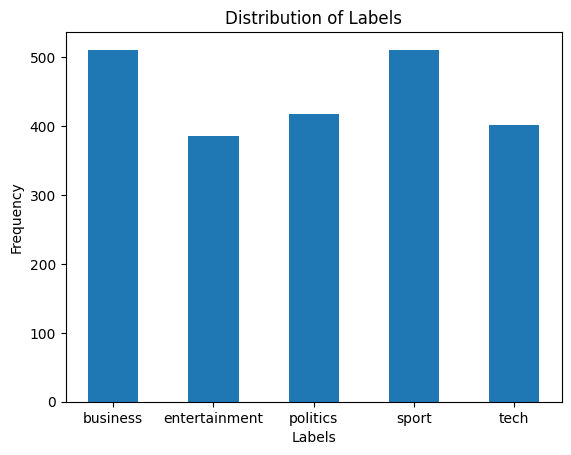

Class Weights: {0: 0.8725490196078431, 1: 1.1528497409326426, 2: 1.0671462829736211, 3: 0.8708414872798435, 4: 1.1097256857855362}


In [21]:
# plotting the label distribution for positive, neutral, negative
plot_label_distribution(data)
class_weights = compute_class_weights(data)
print("Class Weights:", class_weights)

In [22]:
# preprocessing on sample text
text = "The company raised $5.6 M and another EUR2.5b in funding so profits increased by 15%."
processed_text = pre_process(text, word2vec, nlp)
print("Text:", text)
print("Processing Text:", processed_text)

Text: The company raised $5.6 M and another EUR2.5b in funding so profits increased by 15%.
Processing Text: The company raised 3 million another 2 billion EUR in funding so profits increased by 1


In [23]:
# Training and testing split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)
y_true = y_test.argmax(axis=1)

Training Data Shape: (1780, 3963)
Testing Data Shape: (445, 3963)


In [24]:
# Training RNN with ffn model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
rnn_ffn_model = build_rnn_ffn_model(len(vocab), word2vec.vector_size, embedding_matrix, max_length, trainable=True)
rnn_ffn_model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32, class_weight=class_weights, callbacks=[early_stopping])
rnn_ffn_model.summary()
y_true = y_test.argmax(axis=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.2594 - loss: 1.6095 - val_accuracy: 0.3062 - val_loss: 1.5913
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 990ms/step - accuracy: 0.4734 - loss: 1.3315 - val_accuracy: 0.5618 - val_loss: 1.0998
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 984ms/step - accuracy: 0.8144 - loss: 0.6433 - val_accuracy: 0.7219 - val_loss: 0.8643
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 970ms/step - accuracy: 0.9398 - loss: 0.2178 - val_accuracy: 0.7837 - val_loss: 0.6439
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 969ms/step - accuracy: 0.9968 - loss: 0.0414 - val_accuracy: 0.7753 - val_loss: 0.6824
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 968ms/step - accuracy: 1.0000 - loss: 0.0116 - val_accuracy: 0.8034 - val_loss: 0.6858
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 970ms/step - accuracy: 0.9977 - loss: 0.0101 - val_accuracy: 0.8034 - val_loss: 0.7289


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 3963, 300)           │       9,731,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 3963, 64)            │          23,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,315,045 (111.83 MB)

 Trainable params: 9,771,681 (37.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,543,364 (74.55 MB)

In [33]:
# Evaluating RNN model
y_pred_rnn = rnn_ffn_model.predict(X_test).argmax(axis=1)
class_labels = ['business', 'entertainment', 'politics', 'sport', 'tech']
print("RNN Model Evaluation:")
print(classification_report(y_true, y_pred_rnn,target_names=class_labels))

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 366ms/step
RNN Model Evaluation:
               precision    recall  f1-score   support

     business       0.77      0.80      0.78       115
entertainment       0.91      0.83      0.87        72
     politics       0.59      0.71      0.64        76
        sport       0.87      0.79      0.83       102
         tech       0.78      0.72      0.75        80

     accuracy                           0.78       445
    macro avg       0.78      0.77      0.78       445
 weighted avg       0.79      0.78      0.78       445



In [35]:
# Training Complex RNN model
complex_rnn_model = build_complex_rnn_model(len(vocab), word2vec.vector_size, embedding_matrix, max_length)
complex_rnn_model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, class_weight=class_weights, callbacks=[early_stopping])
complex_rnn_model.summary()

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.2758 - loss: 1.5775 - val_accuracy: 0.5983 - val_loss: 1.0910
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.7158 - loss: 0.8283 - val_accuracy: 0.7416 - val_loss: 0.7786
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.8706 - loss: 0.3630 - val_accuracy: 0.8287 - val_loss: 0.5732
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.9548 - loss: 0.1609 - val_accuracy: 0.8006 - val_loss: 0.6516
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.9958 - loss: 0.0331 - val_accuracy: 0.8315 - val_loss: 0.6508
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.9849 - loss: 0.0569 - val_accuracy: 0.8090 - val_loss: 0.6702


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 3963, 300)           │       9,731,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 3963, 128)           │          46,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 128)                 │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,459,045 (112.38 MB)

 Trainable params: 9,819,681 (37.46 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,639,364 (74.92 MB)

In [36]:
# Evaluating Complex RNN model
y_pred_complex_rnn = complex_rnn_model.predict(X_test).argmax(axis=1)
print("RNN Model Evaluation:")
print(classification_report(y_true, y_pred_complex_rnn,target_names=class_labels))

14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 770ms/step
RNN Model Evaluation:
               precision    recall  f1-score   support

     business       0.82      0.82      0.82       115
entertainment       0.79      0.75      0.77        72
     politics       0.92      0.62      0.74        76
        sport       0.87      0.97      0.92       102
         tech       0.69      0.85      0.76        80

     accuracy                           0.81       445
    macro avg       0.82      0.80      0.80       445
 weighted avg       0.82      0.81      0.81       445



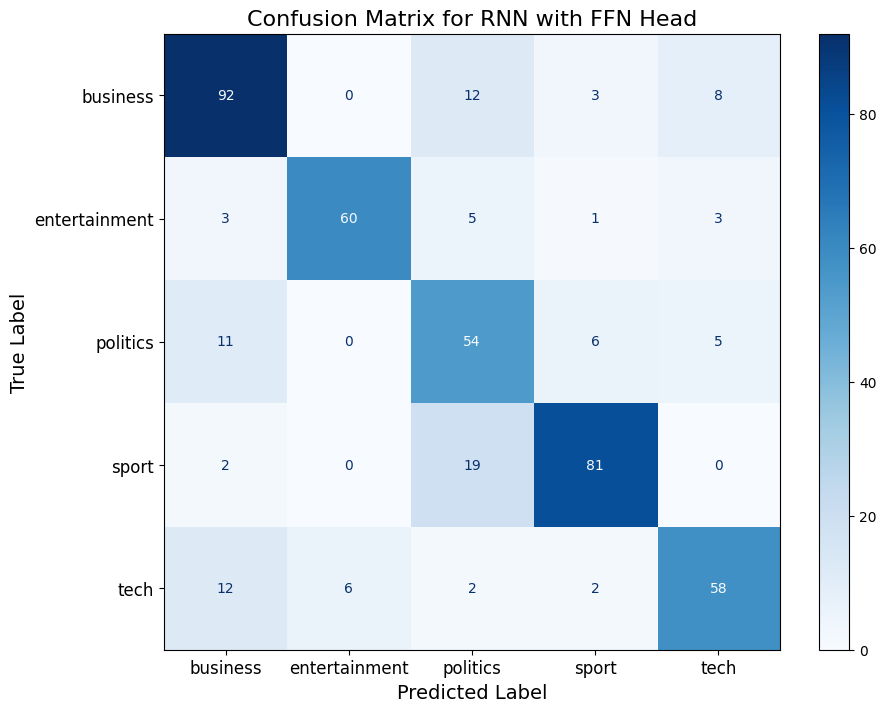

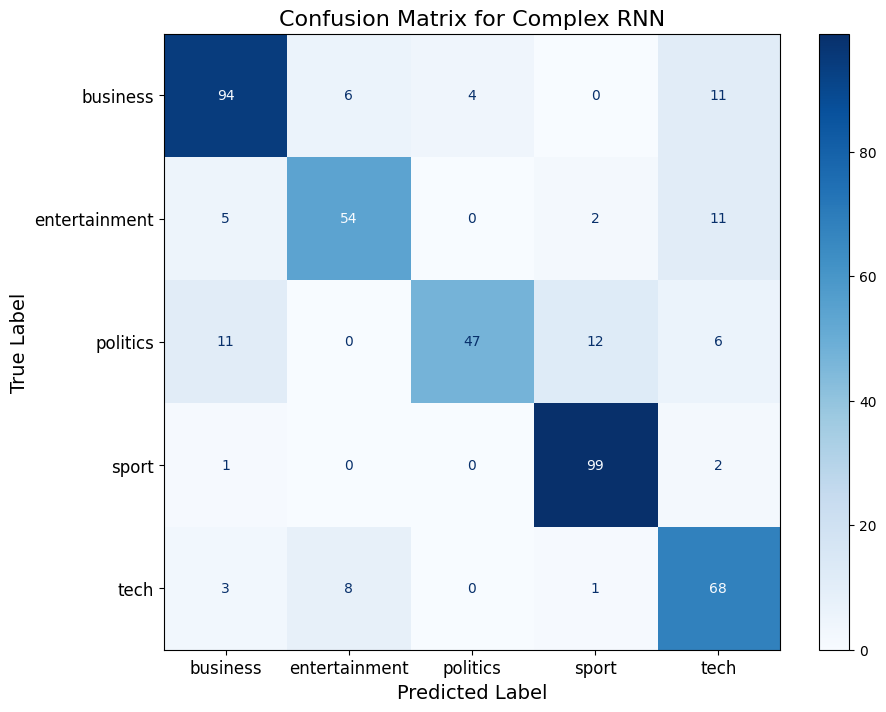

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['business', 'entertainment', 'politics', 'sport', 'tech'])

    # Increase the figure size
    fig, ax = plt.subplots(figsize=(10, 8))  # Larger figure size
    disp.plot(cmap='Blues', values_format='d', ax=ax)

    # Increase font sizes
    plt.title(f"Confusion Matrix for {model_name}", fontsize=16)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

# Confusion Matrix for RNN with FFN Head
plot_confusion_matrix(y_true, y_pred_rnn, model_name="RNN with FFN Head")

# Confusion Matrix for Complex RNN
plot_confusion_matrix(y_true, y_pred_complex_rnn, model_name="Complex RNN")


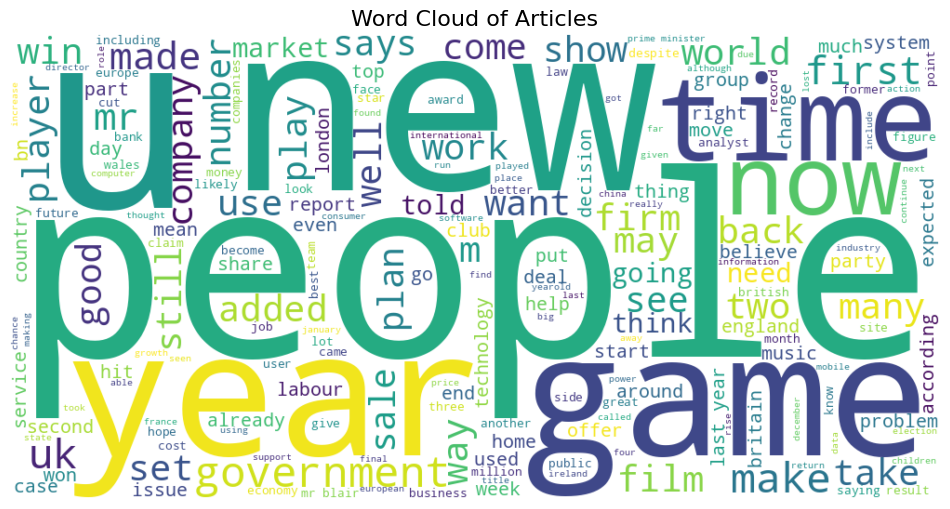

In [50]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

# Load your dataset (assuming 'text' is the column containing the text data)
df = pd.read_csv('bbc_text_cls.csv')  # Replace with your dataset path

# Clean the text data
df['text'] = df['text'].str.replace('[^\w\s]', '', regex=True)  # Remove punctuation
df['text'] = df['text'].str.replace('\d+', '', regex=True)      # Remove numbers
df['text'] = df['text'].str.lower()                             # Convert to lowercase

# Combine all the text from the 'text' column into a single string
text_data = " ".join(df['text'].dropna().values)

# Define additional stop words
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['said', 'will', 'also', 'could', 'would', 'one', 'say'])  # Add more if needed

# Generate the word cloud
wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    colormap='viridis',
    max_words=200,
    stopwords=custom_stopwords  # Remove stop words
).generate(text_data)

# Display the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.title('Word Cloud of Articles', fontsize=16)
plt.show()
